In [1]:
import os # Configure which GPU 
#import sys
import torch
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e) 

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

no_preview = True

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 42

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

/Users/jokuo/Desktop/ECE257B Final Project/env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Num GPUs Available:  0


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement
from sionna.mimo.precoding import normalize_precoding_power, grid_of_beams_dft
from sionna.rt import visualize 
import math

In [3]:
# --- Locate which cell (grid index) a user position falls into ---
def find_cell_index(user_pos, cell_centers, cell_size):
    num_users = user_pos.shape[0]
    cell_zero_pos_x = cell_centers[0,0,0]
    cell_zero_pos_y = cell_centers[0,0,1]
    del_x = cell_size[0]
    del_y = cell_size[1]

    cell_index_x = []
    cell_index_y = []
    distance = []
    
    for user in range(num_users):
        user_pos_x = user_pos[user, 0]
        user_pos_y = user_pos[user, 1]
        x_index = tf.math.floor(((user_pos_x - cell_zero_pos_x) - del_x/2) / del_x + 1)
        y_index = tf.math.floor(((user_pos_y - cell_zero_pos_y) - del_y/2) / del_y + 1)
        cell_index_x.append(int(x_index))
        cell_index_y.append(int(y_index))
        cell_x = cell_centers[int(y_index), int(x_index), 0]
        cell_y = cell_centers[int(y_index), int(x_index), 1]
        dd = tf.math.sqrt((cell_x - user_pos_x)**2 + (cell_y - user_pos_y)**2)
        distance.append(dd)
    return cell_index_x, cell_index_y, distance

# --- Create a boolean coverage map based on RSS threshold ---
def calculate_cover(coveragemap_list, txpow, threshold, limitarea=True, ar_begin=40, ar_end=200, col_begin=50, col_end=250):
    map = np.zeros_like(coveragemap_list[0], dtype=bool)
    mapp = 10. * np.log10(coveragemap_list[0])
    mapp = (mapp + txpow > threshold)
    map = np.logical_or(map, mapp)
    if limitarea:
        map = map[ar_begin:ar_end, col_begin:col_end]
    return map

# --- Generate TX positions split across num_tx blocks of the scene ---
def generate_tx_positions_dynamic(myscene, num_tx, x_points=10, y_points=10, transmitter_height=49.285, x_factor=0.7, y_factor=0.7):
    scene_x_length = myscene.size[0].numpy() * x_factor
    scene_y_length = myscene.size[1].numpy() * y_factor
    scene_center_x = myscene.center[0].numpy()
    scene_center_y = myscene.center[1].numpy()

    grid_rows = int(np.sqrt(num_tx))
    grid_cols = int(np.ceil(num_tx / grid_rows))
    block_x_size = scene_x_length / grid_cols
    block_y_size = scene_y_length / grid_rows

    tx_positions = {}
    block_id = 0
    for i in range(grid_rows):
        for j in range(grid_cols):
            if block_id >= num_tx:
                break
            block_start_x = scene_center_x - (scene_x_length / 2) + j * block_x_size
            block_start_y = scene_center_y - (scene_y_length / 2) + i * block_y_size
            x_array = np.linspace(block_start_x, block_start_x + block_x_size, x_points)
            y_array = np.linspace(block_start_y, block_start_y + block_y_size, y_points)

            block_positions = []
            for x in x_array:
                for y in y_array:
                    block_positions.append([x, y, transmitter_height])

            tx_positions[block_id] = np.array(block_positions, dtype=np.float32)
            block_id += 1
    return tx_positions

# --- Configure a single TX scene ---
def config_scene(scene, num_rows, num_cols, pattern, bs_pwr, tx_pos, look_at=[0,0,0]):
    scene.tx_array = PlanarArray(num_rows=num_rows,
                                 num_cols=num_cols,
                                 vertical_spacing=0.5,
                                 horizontal_spacing=0.5,
                                 pattern=pattern,
                                 polarization="V")
    scene.rx_array = PlanarArray(num_rows=1,
                                 num_cols=1,
                                 vertical_spacing=0.5,
                                 horizontal_spacing=0.5,
                                 pattern="iso",
                                 polarization="V")
    scene.remove('tx')
    scene.add(Transmitter(name='tx',
                          position=tx_pos,
                          look_at=look_at,
                          power_dbm=bs_pwr))
    return scene

# --- Compute the coverage map from a scene ---
def compute_cm(scene):
    cm = scene.coverage_map(
        max_depth=5,
        diffraction=True,
        cm_cell_size=(5., 5.),
        combining_vec=None,
        precoding_vec=None,
        num_samples=int(10e6)
    )
    return cm

# --- Compute SINR mask and count active blocks ---
def calculate_sinr_testing(coveragemap_list, threshold):
    mapp = 10. * np.log10(coveragemap_list[0])
    mapp = (mapp > threshold)
    num_lightup_blocks = np.sum(mapp)
    return mapp, num_lightup_blocks

# --- Convert physical coordinates to grid index ---
def return_geoidx2(pslist):
    x0 = -805.583664
    y0 = -688.600626
    del_x = 5
    del_y = 5
    x, y = pslist[:2]
    x_idx = np.round((x - x0) / del_x)
    y_idx = np.round((y - y0) / del_y)
    return int(x_idx), int(y_idx)

# --- Combine two coverage maps using logical OR and count overlap ---
def compare_sinr_performance(cm_map1, cm_map2):
    overlap_map = np.logical_or(cm_map1, cm_map2)
    num_overlap_blocks = np.sum(overlap_map)
    return overlap_map, num_overlap_blocks

# --- Generate dense TX grid over center of scene ---
def generate_tx_positions(myscene, tx_height=49.285, x_points=100, y_points=100, x_factor=0.7, y_factor=0.7):
    scene_x_length = myscene.size[0].numpy() * x_factor
    scene_y_length = myscene.size[1].numpy() * y_factor
    scene_center_x = myscene.center[0].numpy()
    scene_center_y = myscene.center[1].numpy()
    start_x = scene_center_x - scene_x_length / 2
    start_y = scene_center_y - scene_y_length / 2
    x_array = np.linspace(start_x, start_x + scene_x_length, x_points)
    y_array = np.linspace(start_y, start_y + scene_y_length, y_points)

    tx_positions = np.empty((0, 3), dtype=np.float32)
    for i in range(len(x_array)):
        for j in range(len(y_array)):
            array_temp = np.array([x_array[i], y_array[j], tx_height])
            tx_positions = np.vstack((tx_positions, array_temp))
    return tx_positions, x_array, y_array

# --- Compute SNR map from RSS and noise power ---
def my_snr(rss_map, scene):
    sum_rss = np.sum(rss_map, axis=0)
    noise = scene.thermal_noise_power
    snr_linear = sum_rss / noise
    snr_db = 10 * np.log10(snr_linear)
    snr_db[snr_db < 5] = np.nan
    max_snr = np.nanmax(snr_db)
    blocks_above_threshold = np.sum(~np.isnan(snr_db))
    return snr_db, max_snr, blocks_above_threshold

# --- Plot a 2D SNR heatmap ---
def plot_snr_map(cmapp):
    plt.imshow(cmapp, cmap='viridis', origin='lower')
    plt.colorbar(label="SNR (dB)")
    plt.title("SNR Heatmap")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.show()


Per-antenna TX powers (dBm): {1: 10.0, 2: 6.989700043360188, 4: 3.979400086720376, 8: 0.9691001300805642, 16: -2.041199826559248}
Y grid: [-507.75528564 -477.75528564 -447.75528564 -417.75528564 -387.75528564
 -357.75528564 -327.75528564 -297.75528564 -267.75528564 -237.75528564
 -207.75528564 -177.75528564 -147.75528564 -117.75528564  -87.75528564
  -57.75528564  -27.75528564    2.24471436   32.24471436   62.24471436
   92.24471436  122.24471436  152.24471436  182.24471436  212.24471436
  242.24471436  272.24471436  302.24471436  332.24471436  362.24471436]


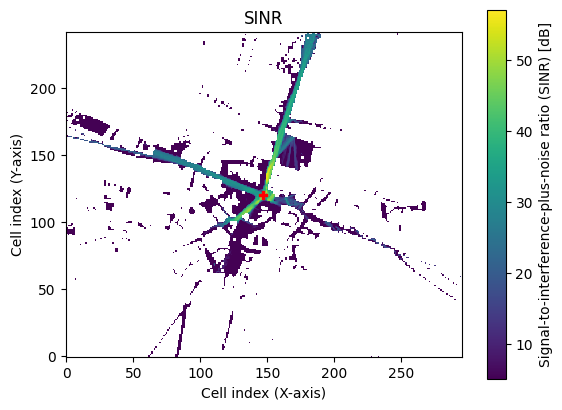

In [4]:
# --- Function to divide total TX power among antennas ---
def divide_power_dBm(P_dBm, N_list):
    """
    Convert total TX power (dBm) into per-antenna power for different array sizes.
    """
    P_linear = 10**(P_dBm / 10)  # Convert dBm to linear (mW)
    power_dict = {N: 10 * np.log10(P_linear / N) for N in N_list}
    return power_dict

# --- Parameters ---
P = 10  # Total TX power in dBm
N_values = [1, 2, 4, 8, 16]  # Different antenna counts to consider

# Compute per-antenna powers
Pw_maps = divide_power_dBm(P, N_values)
print("Per-antenna TX powers (dBm):", Pw_maps)

# --- Load the Munich scene and extract parameters ---
sn = load_scene(sionna.rt.scene.munich)

# Define usable portion of the scene
x_factor = 0.7
y_factor = 0.7

# Compute usable dimensions
scene_x_length = sn.size[0].numpy() * x_factor
scene_y_length = sn.size[1].numpy() * y_factor

# Get scene center
scene_center_x = sn.center[0].numpy()
scene_center_y = sn.center[1].numpy()

# Calculate starting point of usable area (bottom-left corner)
start_x = scene_center_x - (scene_x_length / 2)
start_y = scene_center_y - (scene_y_length / 2)

# Generate Y-axis grid points for visualization or TX placement
y_grid = np.arange(start_y, start_y + scene_y_length + 30, 30)
print("Y grid:", y_grid)


# --- Configure and simulate a 64-element TX using isotropic pattern ---
tx_height = 20  # TX height in meters

# Use power for 1 antenna (no array gain — full 10 dBm used)
scene_1tx_64ant = config_scene(
    scene=sn,
    num_rows=8,
    num_cols=8,
    pattern='iso',
    bs_pwr=Pw_maps[1],  # Power per antenna when N=1
    tx_pos=[scene_center_x, scene_center_y, tx_height]
)

# Compute coverage map (SINR, RSS, etc.)
cm_1tx_64ant = compute_cm(scene_1tx_64ant)

# --- Visualize SINR heatmap ---
im1 = cm_1tx_64ant.show(metric="sinr", vmin=5)  # vmin=5 filters low SINR values

Maximum SNR in the map: 57.13424
Blocks above the threshold: 2903


/var/folders/_w/r7_cn0md5pd8k_yb0ns3xzlm0000gn/T/ipykernel_22555/3446338549.py:148: RuntimeWarning: divide by zero encountered in log10
  snr_db = 10 * np.log10(snr_linear)


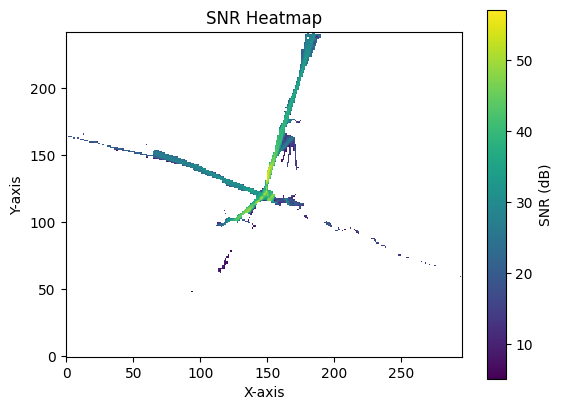

In [5]:
# --- Compute and visualize SNR map for baseline 1TX 64-antenna ISO setup ---
baseline_snr, max_baseline_snr, baseline_blocks = my_snr(cm_1tx_64ant.rss, scene_1tx_64ant)

# Print out the performance summary
print("Maximum SNR in the map:", max_baseline_snr)
print("Blocks above the threshold:", baseline_blocks)

# Plot the SNR heatmap
im2 = plot_snr_map(baseline_snr)


Generated TX positions (2 blocks):
{0: array([[-436.71707 , -387.1917  ,   17.      ],
       [-436.71707 , -186.25243 ,   17.      ],
       [-436.71707 ,   14.68687 ,   17.      ],
       [-436.71707 ,  215.62616 ,   17.      ],
       [-313.76154 , -387.1917  ,   17.      ],
       [-313.76154 , -186.25243 ,   17.      ],
       [-313.76154 ,   14.68687 ,   17.      ],
       [-313.76154 ,  215.62616 ,   17.      ],
       [-190.806   , -387.1917  ,   17.      ],
       [-190.806   , -186.25243 ,   17.      ],
       [-190.806   ,   14.68687 ,   17.      ],
       [-190.806   ,  215.62616 ,   17.      ],
       [ -67.850464, -387.1917  ,   17.      ],
       [ -67.850464, -186.25243 ,   17.      ],
       [ -67.850464,   14.68687 ,   17.      ],
       [ -67.850464,  215.62616 ,   17.      ]], dtype=float32), 1: array([[ -67.850464, -387.1917  ,   17.      ],
       [ -67.850464, -186.25243 ,   17.      ],
       [ -67.850464,   14.68687 ,   17.      ],
       [ -67.850464,  215.626

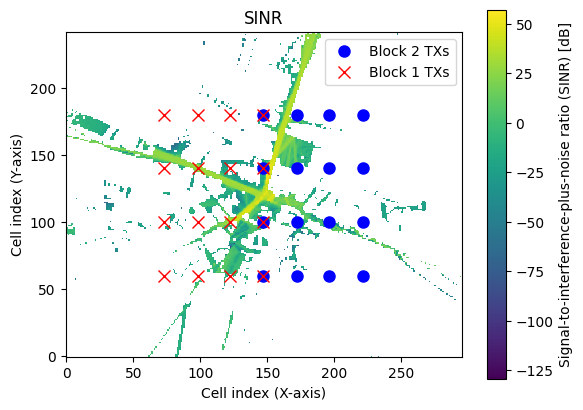

In [6]:
# --- Parameters for TX grid generation ---
TX_height = 17
x_points = 4  # TXs per block in X direction
y_points = 4  # TXs per block in Y direction

# --- Generate positions for 2 TX regions within 50% of the scene area ---
tx_positions = generate_tx_positions_dynamic(
    sn,
    num_tx=2,
    x_points=x_points,
    y_points=y_points,
    transmitter_height=TX_height,
    x_factor=0.5,
    y_factor=0.5
)

print("Generated TX positions (2 blocks):")
print(tx_positions)

# --- Map TX positions in Block 0 to SINR grid cells ---
cell_positions_1 = []
for tx_pos in tx_positions[0]:
    tx_pos_tf = tf.convert_to_tensor([tx_pos], dtype=tf.float32)
    index_x, index_y, distance = find_cell_index(tx_pos_tf, cm_1tx_64ant.cell_centers, cm_1tx_64ant.cell_size)
    cell_positions_1.append(list(zip(index_y, index_x)))

# --- Map TX positions in Block 1 to SINR grid cells ---
cell_positions_2 = []
for tx_pos in tx_positions[1]:
    tx_pos_tf = tf.convert_to_tensor([tx_pos], dtype=tf.float32)
    index_x, index_y, distance = find_cell_index(tx_pos_tf, cm_1tx_64ant.cell_centers, cm_1tx_64ant.cell_size)
    cell_positions_2.append(list(zip(index_y, index_x)))


# --- Display all mapped TX grid positions on SINR map ---
image = cm_1tx_64ant.show(metric='sinr', show_tx=False)

# Add TX markers from block 2 (blue circles)
label_added_2 = False
for positions in cell_positions_2:
    for row, col in positions:
        label = "Block 2 TXs" if not label_added_2 else None
        image.axes[0].plot(col, row, marker='o', color='blue', markersize=8, linestyle='', label=label)
        label_added_2 = True

# Add TX markers from block 1 (red crosses)
label_added_1 = False
for positions in cell_positions_1:
    for row, col in positions:
        label = "Block 1 TXs" if not label_added_1 else None
        image.axes[0].plot(col, row, marker='x', color='red', markersize=8, linestyle='', label=label)
        label_added_1 = True

# Show the final image with legend
image.axes[0].legend()
plt.show()


In [7]:
# --- Load fresh scene for coverage simulation ---
scene2 = load_scene(sionna.rt.scene.munich)

# Basic scene setup
scene2.bandwidth = 100e6
scene2.frequency = 2.14e9
scene2.synthetic_array = True

sinr_TH = 5  # SINR threshold in dB
x, y = [], []

# --- Prepare TX position dictionaries for easier reference later ---
tx1_loc_dict = {i: pos for i, pos in enumerate(tx_positions[0])}
tx2_loc_dict = {i: pos for i, pos in enumerate(tx_positions[1])}

# --- Store coverage maps (boolean masks) for each TX candidate ---
coverage_TX1 = {}
coverage_TX2 = {}

# --- Evaluate each candidate in TX Block 1 ---
for i, pos in enumerate(tx_positions[0]):
    print(f"TX1 candidate {i}: {pos}")
    
    # Reconfigure scene with current TX
    scene2 = config_scene(scene2, 4, 8, 'iso', Pw_maps[2], pos)
    cm2 = compute_cm(scene2)

    # Evaluate SINR mask
    sinr_cover, number_lightup_blk = calculate_sinr_testing(cm2.sinr, sinr_TH)
    print("Covered blocks:", number_lightup_blk)

    # Store mask
    coverage_TX1[i] = sinr_cover
# --- Evaluate each candidate in TX Block 2 ---
for i, pos in enumerate(tx_positions[1]):
    print(f"TX2 candidate {i}: {pos}")
    
    # Reconfigure scene with current TX
    scene2 = config_scene(scene2, 4, 8, 'iso', Pw_maps[2], pos)
    cm2 = compute_cm(scene2)

    # Evaluate SINR mask
    sinr_cover, number_lightup_blk = calculate_sinr_testing(cm2.sinr, sinr_TH)
    print("Covered blocks:", number_lightup_blk)

    # Store mask
    coverage_TX2[i] = sinr_cover


TX1 candidate 0: [-436.71707 -387.1917    17.     ]


/var/folders/_w/r7_cn0md5pd8k_yb0ns3xzlm0000gn/T/ipykernel_22555/3446338549.py:103: RuntimeWarning: divide by zero encountered in log10
  mapp = 10. * np.log10(coveragemap_list[0])


Covered blocks: 302
TX1 candidate 1: [-436.71707 -186.25243   17.     ]
Covered blocks: 283
TX1 candidate 2: [-436.71707   14.68687   17.     ]
Covered blocks: 174
TX1 candidate 3: [-436.71707  215.62616   17.     ]
Covered blocks: 2519
TX1 candidate 4: [-313.76154 -387.1917    17.     ]
Covered blocks: 1105
TX1 candidate 5: [-313.76154 -186.25243   17.     ]
Covered blocks: 81
TX1 candidate 6: [-313.76154   14.68687   17.     ]
Covered blocks: 1555
TX1 candidate 7: [-313.76154  215.62616   17.     ]
Covered blocks: 1219
TX1 candidate 8: [-190.806  -387.1917   17.    ]
Covered blocks: 974
TX1 candidate 9: [-190.806   -186.25243   17.     ]
Covered blocks: 1218
TX1 candidate 10: [-190.806     14.68687   17.     ]
Covered blocks: 115
TX1 candidate 11: [-190.806    215.62616   17.     ]
Covered blocks: 2273
TX1 candidate 12: [ -67.850464 -387.1917     17.      ]
Covered blocks: 3115
TX1 candidate 13: [ -67.850464 -186.25243    17.      ]
Covered blocks: 733
TX1 candidate 14: [-67.850464  

In [8]:
max_overlap = float('-inf')          # Track max number of covered blocks
best_tx_loc = (None, None)           # Store best pair of TX positions
optimal_map = 0                      # Final combined SINR map

# --- Evaluate all (TX1, TX2) combinations ---
for key1, val1 in coverage_TX1.items():
    for key2, val2 in coverage_TX2.items():
        
        # Avoid selecting the exact same position from both blocks (just in case)
        if np.array_equal(tx1_loc_dict[key1], tx2_loc_dict[key2]):
            continue

        # Combine coverage from both TXs
        overlap_map, num_overlap_blocks_temp = compare_sinr_performance(val1, val2)

        # Keep the combination with maximum joint coverage
        if num_overlap_blocks_temp > max_overlap:
            max_overlap = num_overlap_blocks_temp
            optimal_map = overlap_map
            best_tx_loc = (tx1_loc_dict[key1], tx2_loc_dict[key2])

# --- Output the best performing TX positions ---
print("Best TX Location Pair Found:")
print("  TX1 Position:", best_tx_loc[0])
print("  TX2 Position:", best_tx_loc[1])
print("  Max Overlap (covered blocks):", max_overlap)


Best TX Location Pair Found:
  TX1 Position: [ -67.850464 -387.1917     17.      ]
  TX2 Position: [ 301.01614 -387.1917    17.     ]
  Max Overlap (covered blocks): 5880


In [9]:
# --- Load fresh scene ---
scene2 = load_scene(sionna.rt.scene.munich)

# Basic scene setup
scene2.bandwidth = 100e6
scene2.frequency = 2.14e9
scene2.synthetic_array = True

# SINR threshold for coverage
sinr_TH = 5

# --- Generate candidate look-at directions (on a grid at 0 height) ---
look_at_height = 0
look_at_pos, _, _ = generate_tx_positions(
    sn, 
    tx_height=look_at_height, 
    x_points=5, 
    y_points=5, 
    x_factor=0.7, 
    y_factor=0.7
)

# Map indices to look-at positions for reference
look_at_dict = {i: look_at for i, look_at in enumerate(look_at_pos)}
print("Look-at positions:")
print(look_at_dict)

# --- Sweep all look-at directions for both TXs (best positions from previous step) ---
coverage_1 = {}  # For TX1
coverage_2 = {}  # For TX2

for i, txpos in enumerate(best_tx_loc):
    print(f"\nEvaluating TX{i+1} at position: {txpos}")

    for j, look_at in enumerate(look_at_pos):
        print(f"  → Look-at direction {j}: {look_at}")

        # Configure scene for this TX + look-at
        scene2 = config_scene(
            scene2,
            num_rows=4,
            num_cols=8,
            pattern='iso',
            bs_pwr=Pw_maps[2],
            tx_pos=txpos,
            look_at=look_at
        )

        # Compute coverage map and check SINR mask
        cm2 = compute_cm(scene2)
        sinr_cover, number_lightup_blk = calculate_sinr_testing(cm2.sinr, sinr_TH)
        print(f"    Covered blocks: {number_lightup_blk}")

        # Store results separately for each TX
        if i == 0:
            coverage_1[j] = sinr_cover
        else:
            coverage_2[j] = sinr_cover


Look-at positions:
{0: array([-584.2637146 , -507.75528564,    0.        ]), 1: array([-584.2637146 , -296.76903076,    0.        ]), 2: array([-584.2637146 ,  -85.78277588,    0.        ]), 3: array([-584.2637146,  125.203479 ,    0.       ]), 4: array([-584.2637146 ,  336.18973389,    0.        ]), 5: array([-326.05708923, -507.75528564,    0.        ]), 6: array([-326.05708923, -296.76903076,    0.        ]), 7: array([-326.05708923,  -85.78277588,    0.        ]), 8: array([-326.05708923,  125.203479  ,    0.        ]), 9: array([-326.05708923,  336.18973389,    0.        ]), 10: array([ -67.85046387, -507.75528564,    0.        ]), 11: array([ -67.85046387, -296.76903076,    0.        ]), 12: array([-67.85046387, -85.78277588,   0.        ]), 13: array([-67.85046387, 125.203479  ,   0.        ]), 14: array([-67.85046387, 336.18973389,   0.        ]), 15: array([ 190.3561615 , -507.75528564,    0.        ]), 16: array([ 190.3561615 , -296.76903076,    0.        ]), 17: array([190.3

/var/folders/_w/r7_cn0md5pd8k_yb0ns3xzlm0000gn/T/ipykernel_22555/3446338549.py:103: RuntimeWarning: divide by zero encountered in log10
  mapp = 10. * np.log10(coveragemap_list[0])


    Covered blocks: 3601
  → Look-at direction 1: [-584.2637146  -296.76903076    0.        ]
    Covered blocks: 3606
  → Look-at direction 2: [-584.2637146   -85.78277588    0.        ]
    Covered blocks: 3196
  → Look-at direction 3: [-584.2637146  125.203479     0.       ]
    Covered blocks: 3277
  → Look-at direction 4: [-584.2637146   336.18973389    0.        ]
    Covered blocks: 3281
  → Look-at direction 5: [-326.05708923 -507.75528564    0.        ]
    Covered blocks: 2893
  → Look-at direction 6: [-326.05708923 -296.76903076    0.        ]
    Covered blocks: 2662
  → Look-at direction 7: [-326.05708923  -85.78277588    0.        ]
    Covered blocks: 2880
  → Look-at direction 8: [-326.05708923  125.203479      0.        ]
    Covered blocks: 3561
  → Look-at direction 9: [-326.05708923  336.18973389    0.        ]
    Covered blocks: 3578
  → Look-at direction 10: [ -67.85046387 -507.75528564    0.        ]
    Covered blocks: 3076
  → Look-at direction 11: [ -67.85046

Best beam directions (look-at positions):
  TX1 look-at: [190.3561615 125.203479    0.       ]
  TX2 look-at: [ 190.3561615  -507.75528564    0.        ]
  Overlap (covered blocks): 6505


/var/folders/_w/r7_cn0md5pd8k_yb0ns3xzlm0000gn/T/ipykernel_22555/3446338549.py:103: RuntimeWarning: divide by zero encountered in log10
  mapp = 10. * np.log10(coveragemap_list[0])


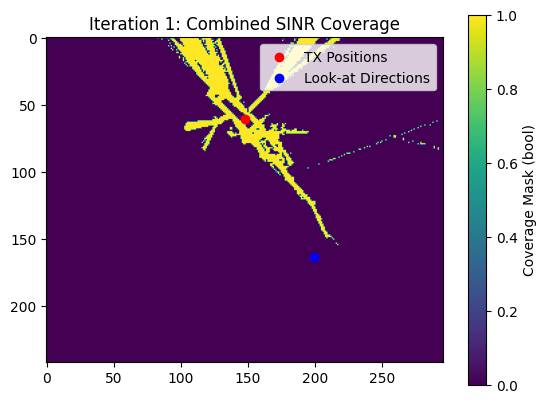

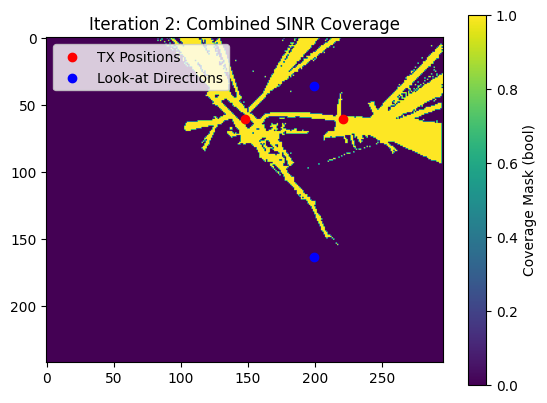

In [11]:
# --- Find best combination of look-at directions for both TXs ---
max_overlap = float('-inf')
best_look_at_loc = (None, None)
optimal_map = 0

for key1, val1 in coverage_1.items():
    for key2, val2 in coverage_2.items():
        overlap_map, num_overlap_blocks_temp = compare_sinr_performance(val1, val2)
        
        if num_overlap_blocks_temp > max_overlap:
            max_overlap = num_overlap_blocks_temp
            optimal_map = overlap_map
            best_look_at_loc = (look_at_dict[key1], look_at_dict[key2])

print("Best beam directions (look-at positions):")
print("  TX1 look-at:", best_look_at_loc[0])
print("  TX2 look-at:", best_look_at_loc[1])
print("  Overlap (covered blocks):", max_overlap)


# --- Setup clean scene for final 2-TX simulation ---
sn2 = load_scene(sionna.rt.scene.munich)
sn2.bandwidth = 100e6
sn2.frequency = 2.14e9
sn2.synthetic_array = False  # Realistic (non-ideal) antennas

# Tracking
sinr_TH = 5
rss_TH = -100
x = [] 
y = []
x_theory = []
y_theory = []
sinr_cover = 0  # Initialize combined coverage

# --- Simulate and combine both optimized TXs ---
for i, tx_pos in enumerate(best_tx_loc):
    plt.figure()
    
    # Record grid locations (for scatter plot)
    x_tx, y_tx = return_geoidx2(tx_pos)
    x_look, y_look = return_geoidx2(best_look_at_loc[i])
    x_theory.append(x_tx)
    y_theory.append(y_tx)
    x.append(x_look)
    y.append(y_look)
    
    # Configure and simulate one TX with its beam direction
    sn_2tx = config_scene(sn2, 4, 8, 'iso', Pw_maps[2], tx_pos, best_look_at_loc[i])
    cm_2tx = compute_cm(sn_2tx)

    # Compute SINR mask and combine into full map
    sinr_cover_temp, _ = calculate_sinr_testing(cm_2tx.sinr, sinr_TH)
    sinr_cover, _ = compare_sinr_performance(sinr_cover, sinr_cover_temp)

    # --- Plotting ---
    plt.scatter(x_theory, y_theory, label="TX Positions", color='red')
    plt.scatter(x, y, label="Look-at Directions", color='blue')
    plt.imshow(sinr_cover, cmap='viridis')
    plt.title(f"Iteration {i+1}: Combined SINR Coverage")
    plt.colorbar(label="Coverage Mask (bool)")
    plt.legend()
    plt.show()


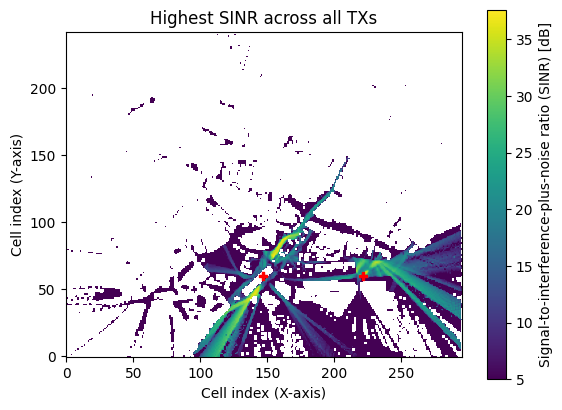

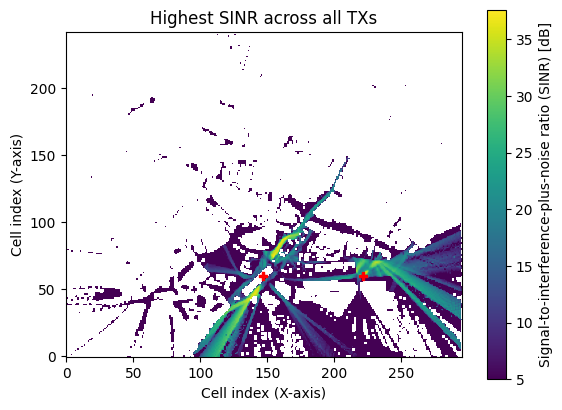

In [12]:
# --- Function: Add one transmitter to the scene for MISO simulation ---
def config_scene_MISO(scene, num_rows, num_cols, pattern, bs_pwr, tx_pos, iter_num, look_at=[0,0,0]):
    """
    Adds a transmitter to the scene with a unique name for MISO config.
    """
    scene.bandwidth = 100e6
    scene.frequency = 2.14e9
    scene.synthetic_array = True

    # TX array configuration
    scene.tx_array = PlanarArray(
        num_rows=num_rows,
        num_cols=num_cols,
        vertical_spacing=0.5,
        horizontal_spacing=0.5,
        pattern=pattern,
        polarization="V"
    )

    # RX is fixed (1x1 isotropic)
    scene.rx_array = PlanarArray(
        num_rows=1,
        num_cols=1,
        vertical_spacing=0.5,
        horizontal_spacing=0.5,
        pattern="iso",
        polarization="V"
    )

    # Add transmitter with unique name (e.g., 'tx0', 'tx1')
    scene.add(Transmitter(
        name=f'tx{iter_num}',
        position=tx_pos,
        look_at=look_at,
        power_dbm=bs_pwr
    ))

    return scene
    
# --- Load fresh scene ---
scene2 = load_scene(sionna.rt.scene.munich)
sinr_TH = 5

# --- Add both transmitters into the same scene (MISO setup) ---
for i, tx_pos in enumerate(best_tx_loc):
    scene2 = config_scene_MISO(
        scene=scene2,
        num_rows=4,
        num_cols=8,
        pattern='iso',
        bs_pwr=Pw_maps[2],             # Split total power evenly
        tx_pos=tx_pos,
        iter_num=i,
        look_at=best_look_at_loc[i]
    )

# --- Compute the full MISO coverage map ---
cm_2tx_real = compute_cm(scene2)

# --- Visualize the SINR map ---
cm_2tx_real.show(metric="sinr", vmin=5)  # vmin=5 to filter low SINR values


Maximum SNR in the map:  37.664177
Blocks above the threshold:  6414


/var/folders/_w/r7_cn0md5pd8k_yb0ns3xzlm0000gn/T/ipykernel_22555/3446338549.py:148: RuntimeWarning: divide by zero encountered in log10
  snr_db = 10 * np.log10(snr_linear)


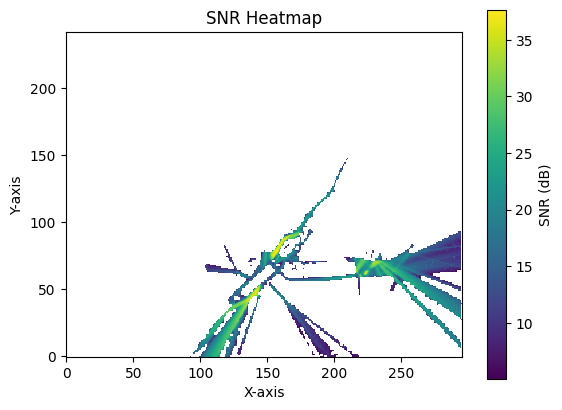

In [13]:
snr, max_snr, blocks = my_snr(cm_2tx_real.rss, scene2)
print("Maximum SNR in the map: ", max_snr)
print("Blocks above the threshold: ", blocks)
plot_snr_map(snr)

In [14]:
scene2.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …